In [1]:
import pandas as pd
from module.function import *
from module.learning import *
import tensorflow as tf

C:\Users\SEO09\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from Crawl import *

In [3]:
coin_list = 'TRX,NEO,BLZ,ICX,EOS,VEN,XRP,ADA,XLM,FUN,BNB,DGD,LTC,IOTA,CTR,WTC,CND,QSP,OMG,PPT,ZRX,IOST,GXS,XVG,BQX,LSK,REQ,POWR,POE,ELF,QTUM,ENG,BTS,AION,XMR,VIBE,SNT,KNC,ETC,MANA,VIB,LEND,SUB,OST,SALT,ZEC,ENJ,NEBL,HSR,NULS,LINK,BCD,LRC,WABI,TNB,GTO,ARK,TRIG,DASH,APPC,STRAT,MTL,SNGLS,MDA,INS,GVT,TNT,AST,BAT,BTG,MCO,CDT,LUN,ARN,AMB,WAVES,ADX,FUEL,BRD,RCN,XZC,MOD,NAV,EVX,DNT,KMD,BNT,ICN,BCPT,STORJ,DLT,EDO,WINGS,SNM,MTH,OAX,YOYO'.split(',')

In [4]:
coin_dict = {}
for i in coin_list:
    coin_dict[i] = pd.read_csv('data_csv/data_{}_KRW.csv'.format(i)).drop(['Unnamed: 0'], axis = 1)

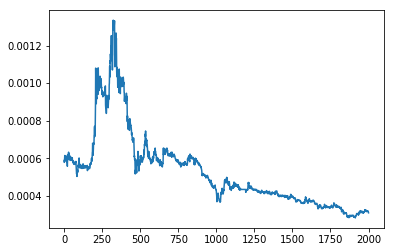

In [5]:
plt.close()
plt.plot(coin_dict['ADA'].close)
plt.show()

In [6]:
ada = coin_dict['ADA']

In [7]:
price = np.array(ada.close) + np.array(1e-7)
volume = np.array(ada.volumeto) + np.array(1e-7)

In [8]:
interval = 24
price_del = [(price[i+interval]-price[i])*100/price[i] for i in range(len(price)-interval)] # 가격 변화율
volume_del = [(volume[i+interval]-volume[i])*100/volume[i] for i in range(len(volume)-interval)] # 거래량 변화율
        price_std = [np.std(price[i:i+interval])*100/np.mean(price[i:i+interval]) for i in range(len(price)-interval)] # 가격변화율 표준편차
volume_std = [np.std(volume[i:i+interval])*100/np.mean(volume[i:i+interval]) for i in range(len(volume)-interval)] # 거래량 변화율 표준편차

In [9]:
seq_length = 24 # batch size
data_dim = 4 # 입력 데이터가 몇개인가? 여기서는 네개(가격변화율, 거래량변화율, 가격표편, 거래량표편)
output_dim = 1 # 다음시간째(25)가격 상승률을 출력
hidden_dim = 20 # 뉴런 수

In [10]:
x = np.array([price_del, volume_del, price_std, volume_std]).T # 학습에 쓰이는 데이터
y = np.array([price_del]).T #답(24시간동안의 양상을 바탕으로 다음 1시간후(25시간)의 상승률)

In [11]:
dataX = []
dataY = []
for i in range(len(y) - seq_length):
    _x = x[i:i+seq_length]
    _y = y[i]
    dataX.append(_x) # data with previous data
    dataY.append(_y) # label

In [12]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataX)])

In [13]:
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None,1])

In [14]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units = hidden_dim, state_is_tuple = True)
output, state = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
Y_pred = tf.contrib.layers.fully_connected(output[:,-1], output_dim, activation_fn = None)

In [15]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))

opt = tf.train.AdamOptimizer(0.01)
train = opt.minimize(loss)

In [16]:
print('start learning')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('initialized')

start learning
initialized


In [17]:
for i in range(2000):
    tr, l = sess.run([train, loss], feed_dict = {X: trainX, Y: trainY})
    if i%100 == 0:
        print('cycle {} of 2000 done \r'.format(i))

cycle 0 of 2000 done 
cycle 100 of 2000 done 
cycle 200 of 2000 done 
cycle 300 of 2000 done 
cycle 400 of 2000 done 
cycle 500 of 2000 done 
cycle 600 of 2000 done 
cycle 700 of 2000 done 
cycle 800 of 2000 done 
cycle 900 of 2000 done 
cycle 1000 of 2000 done 
cycle 1100 of 2000 done 
cycle 1200 of 2000 done 
cycle 1300 of 2000 done 
cycle 1400 of 2000 done 
cycle 1500 of 2000 done 
cycle 1600 of 2000 done 
cycle 1700 of 2000 done 
cycle 1800 of 2000 done 
cycle 1900 of 2000 done 


In [18]:
testPred = sess.run(Y_pred, feed_dict = {X: testX})

C:\Users\SEO09\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


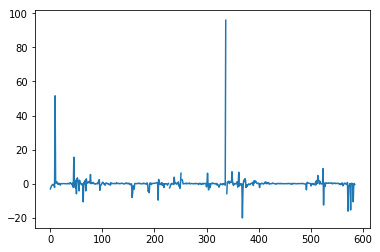

In [19]:
plt.plot((testY-testPred)/testY)

plt.show()

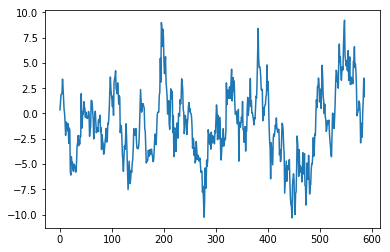

In [20]:
plt.plot(testY)
plt.show()

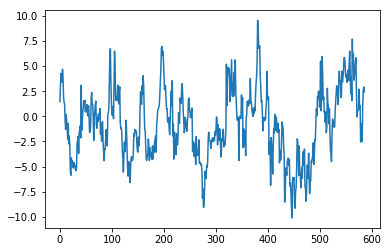

In [22]:
plt.plot(testPred)

plt.show()

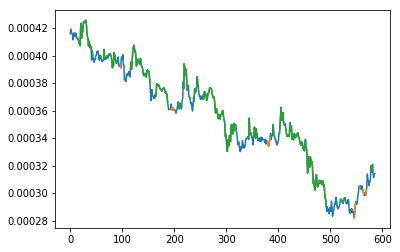

In [31]:
testprice = price[train_size:len(dataX)]
plt.plot(testprice)
buy = [testprice[i] if testPred[i] > 5 else None for i in range(len(testprice)) ] #오렌지색 # 5퍼증가할 확률
sell = [testprice[i] if testPred[i] < 0 else None for i in range(len(testprice)) ] # green
plt.plot(buy)
plt.plot(sell)
plt.show() 

In [32]:
xrp = coin_dict['ADA']
price2 = xrp.close

testPred2 = sess.run(Y_pred, feed_dict = {X: testX})

In [ ]:
testprice2 = price2[train_size:len(dataX)]
plt.plot(testprice2)
buy2 = [testprice2[i] if testPred[i] > 5 else None for i in range(len(testprice2)) ] #오렌지색 # 5퍼증가할 확률
sell2 = [testprice2[i] if testPred[i] < 0 else None for i in range(len(testprice2)) ] # green
plt.plot(buy)
plt.plot(sell)
plt.show() 